In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import time
sys.path.append('../')

from util import *
from fico_util import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
Taa = np.linspace(0.2,0.85,5)
Tc = np.linspace(0.45,0.85,5)
print(Taa,Tc)

[0.2    0.3625 0.525  0.6875 0.85  ] [0.45 0.55 0.65 0.75 0.85]
[0.2    0.3625 0.525  0.6875 0.85  ] [0.45 0.55 0.65 0.75 0.85]


## Define a model for the study of long-term impact of fairness contraints in FICO

### Initial qualification rates 
The qualification rates are $\alpha^0=0.34$ and  $\alpha^1=0.76$.  
The demographic proportions are $P(S=0)=0.12$ and $P(S=1)=0.88$.

In [3]:
P_C = 0.88
P_AA = 0.12

alpha_aa_ini=0.34
alpha_c_ini=0.76

In [4]:

a_aa0= 1.07
b_aa0= 6.07
a_aa1= 1.62
b_aa1= 1.76

a_c0=1.02
b_c0=3.68
a_c1=2.12
b_c1=1.16

### Transition probability 
-  $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$, represented by an array T[ y, a, s]: the probability to be qualified given the current qualification state $Y_t=y$, decision $A_t = a$, and the group $S=s$, i.e.,
- The following defined transition is under Condition 1(ii) in the paper.


### Dynamics
$\alpha^s_{t+1} = g^{0s}_t + (g^{1s}_t-g^{0s}_t) \alpha^s_t$.  
- $g^{0s}_t = T[0,0,s]\mathbb{E}_{X\mid 0,s}(\hat{Y} = 0) + T[0,1,s] \mathbb{E}_{X\mid 0,s}(\hat{Y} = 1)$  
- $g^{1s}_t = T[1,0,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 0) + T[1,1,s] \mathbb{E}_{X\mid 1,s}(\hat{Y} = 1)$
- T[ y, a, s] represents $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$.  
- E[ y, a, s] represents $\mathbb{E}_{X\mid y,s}(\hat{Y} = a)$.

In [5]:
def update(alpha,tpr,fpr,T, group):
    g0 = T[0,0,group]*(1-fpr[group]) + T[0,1,group]*fpr[group]
    g1 = T[1,0,group]*(1-tpr[group]) + T[1,1,group]*tpr[group]
    return alpha*g1 + (1-alpha)*g0

In [6]:
def balance_diff(alpha,tpr,fpr,T, group):
    g0 = T[0,0,group]*(1-fpr[group]) + T[0,1,group]*fpr[group]
    g1 = T[1,0,group]*(1-tpr[group]) + T[1,1,group]*tpr[group]    
    return g0 + (g1-g0-1)*alpha 

### The evolution trajectory of qualification rates   

In this study, we consider the demographic invariant generation case. The generation distribution is not changed over time, but the ratio of different subgroups is changed, i.e., the qualification rate. Therefore, we can use resampling to get the dataset at each time step.

*The algorithm:*
1. Compute the ratio for each subgroup;  
2. Sample from the original dataset according to the subgroup-wised ratio;  
3. Apply a classifier to estimating the decision boundary;
4. Apply the dynamics to compute the ratio in next time step.
 

In [7]:
def update_qualification_rates(alpha_aa, alpha_c, T, policy,
                               fn=None, Pf_aa=None, Pf_c=None,
                               paa=P_AA, pc=P_C,
                               a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                               a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1):
    
    tpr,fpr = eva_classifier_fn(alpha_aa,alpha_c, policy,fn, Pf_aa, Pf_c,
                             paa, pc,
                             a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                             a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1)  
    
    alpha_aa_next = update(alpha_aa,tpr,fpr,T,group = 0)
    alpha_c_next = update(alpha_c,tpr,fpr,T,group = 1)
    return alpha_aa_next,alpha_c_next

In [8]:
def compute_balance_diff(alpha_aa, alpha_c, T, policy,
                         fn=None, Pf_aa=None, Pf_c=None,
                         paa=P_AA, pc=P_C,
                         a_aa0=a_aa0,b_aa0=b_aa0,a_aa1=a_aa1,b_aa1=b_aa1,
                         a_c0=a_c0,b_c0=b_c0,a_c1=a_c1,b_c1=b_c1):
    
    tpr,fpr = eva_classifier_fn(alpha_aa,alpha_c,policy,fn, Pf_aa, Pf_c,
                             paa,pc,
                             a_aa0,b_aa0,a_aa1,b_aa1,
                             a_c0,b_c0,a_c1,b_c1)    
    group0 = balance_diff(alpha_aa,tpr,fpr,T,group=0)
    group1 = balance_diff(alpha_c,tpr,fpr,T,group=1)
    return group0, group1

### Evolution behavior in the UN case
**Evolution behavior.** Starting from different qualification rates, we can see the evolution behavior. The figure indicates that in the UN case, qualification rates converge to an unique equiibria.

4

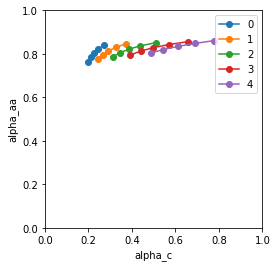

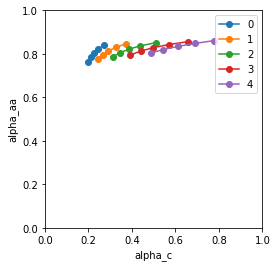

In [9]:
# Define the transition matrix under Condition 1(ii)
# The order of index in T: 
# ["qualification state", "decision", "group"]
MAX_ITERATION_EQUILIBRIUM = 10


T = np.zeros((2, 2, 2))
plt.figure()
plt.axis('square')
TList = np.linspace(0.1,0.9,5)


un_eq_all0 = []
un_eq_all1 = []

Taa = np.linspace(0.2,0.85,5)
Tc = np.linspace(0.45,0.85,5)

for j in range(5):
    sys.stdout.write("\r{0}".format(str(j)))
    un_eq0 = []
    un_eq1 = []
    for i in range(5):
        T[0,0,0] = 0.1 # "AA"
        T[0,1,0] = Taa[i]
        T[1,0,0] = Taa[j]
        T[1,1,0] = 0.9

        T[0,0,1] = 0.4
        T[0,1,1] = Tc[i]
        T[1,0,1] = Tc[j]
        T[1,1,1] = 0.9
        np.random.seed(777)

        # The UN case
        alpha0, alpha1 =  alpha_aa_ini,alpha_c_ini
        alpha0_un_evolution=[alpha0]
        alpha1_un_evolution=[alpha1]
        for _ in range(MAX_ITERATION_EQUILIBRIUM):
            alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'UN',
                                       fn=None, Pf_aa=None, Pf_c=None,
                                       paa=P_AA, pc=P_C,
                                       a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                                       a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1)
            alpha0_un_evolution.append(alpha0)
            alpha1_un_evolution.append(alpha1)
        
        un_eq0.append(alpha0)
        un_eq1.append(alpha1)
    un_eq_all0.append(un_eq0)
    un_eq_all1.append(un_eq1)
    plt.plot(un_eq0,un_eq1,'o-',label=str(j))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
plt.xlabel('alpha_c')
plt.ylabel('alpha_aa')
plt.legend()
plt.show()


4

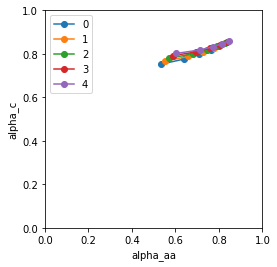

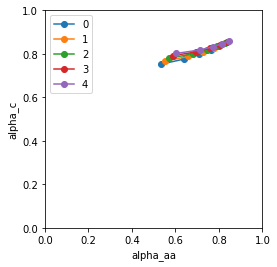

In [11]:
# Define the transition matrix under Condition 1(ii)
# The order of index in T: 
# ["qualification state", "decision", "group"]
MAX_ITERATION_EQUILIBRIUM = 10


T = np.zeros((2, 2, 2))
plt.figure()
plt.axis('square')
TList = np.linspace(0.1,0.9,5)


dp_eq_all0 = []
dp_eq_all1 = []

Taa = np.linspace(0.2,0.85,5)
Tc = np.linspace(0.45,0.85,5)

for j in range(5):
    sys.stdout.write("\r{0}".format(str(j)))
    dp_eq0 = []
    dp_eq1 = []

    for i in range(5):
        T[0,0,0] = 0.1 # "AA"
        T[0,1,0] = Taa[i]
        T[1,0,0] = Taa[j]
        T[1,1,0] = 0.9

        T[0,0,1] = 0.4
        T[0,1,1] = Tc[i]
        T[1,0,1] = Tc[j]
        T[1,1,1] = 0.9
        np.random.seed(777)

            
        alpha0, alpha1 =  alpha_aa_ini,alpha_c_ini
        alpha0_dp_evolution=[alpha0]
        alpha1_dp_evolution=[alpha1]
        for _ in range(MAX_ITERATION_EQUILIBRIUM):
            alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'DP',f_dp, Pdp_aa, Pdp_c,
                                                        paa=P_AA, pc=P_C,
                                                        a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                                                        a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1
                                                       )
            alpha0_dp_evolution.append(alpha0)
            alpha1_dp_evolution.append(alpha1)  
        
        dp_eq0.append(alpha0)
        dp_eq1.append(alpha1)
    dp_eq_all0.append(dp_eq0)
    dp_eq_all1.append(dp_eq1)
    plt.plot(dp_eq0,dp_eq1,'o-',label=str(j))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
plt.xlabel('alpha_aa')
plt.ylabel('alpha_c')
plt.legend()
plt.show()



4

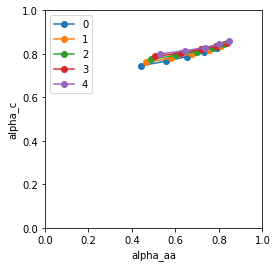

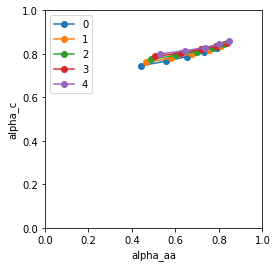

In [12]:
# Define the transition matrix under Condition 1(ii)
# The order of index in T: 
# ["qualification state", "decision", "group"]
MAX_ITERATION_EQUILIBRIUM = 5


T = np.zeros((2, 2, 2))
plt.figure()
plt.axis('square')
Taa = np.linspace(0.2,0.85,5)
Tc = np.linspace(0.45,0.85,5)
eqopt_all0 = []
eqopt_all1 = []

for j in range(5):
    sys.stdout.write("\r{0}".format(str(j)))
    eqopt_eq0 = []
    eqopt_eq1 = []
    for i in range(5):
        T[0,0,0] = 0.1 # "AA"
        T[0,1,0] = Taa[i]
        T[1,0,0] = Taa[j]
        T[1,1,0] = 0.9

        T[0,0,1] = 0.4
        T[0,1,1] = Tc[i]
        T[1,0,1] = Tc[j]
        T[1,1,1] = 0.9
        np.random.seed(777)

        # The EqOpt case
        alpha0, alpha1 =  alpha_aa_ini,alpha_c_ini
        alpha0_eqopt_evolution=[alpha0]
        alpha1_eqopt_evolution=[alpha1]
        for _ in range(MAX_ITERATION_EQUILIBRIUM):
            alpha0, alpha1 = update_qualification_rates(alpha0, alpha1, T, 'EqOpt',f_eqopt, Peqopt_aa, Peqopt_c,
                                                        paa=P_AA, pc=P_C,
                                                        a_aa0=a_aa0, b_aa0=b_aa0,a_aa1=a_aa1, b_aa1=b_aa1,
                                                        a_c0=a_c0, b_c0=b_c0, a_c1=a_c1, b_c1=b_c1
                                                       )
        alpha0_eqopt_evolution.append(alpha0)
        alpha1_eqopt_evolution.append(alpha1)  

        eqopt_eq0.append(alpha0)
        eqopt_eq1.append(alpha1)
    eqopt_all0.append(eqopt_eq0)
    eqopt_all1.append(eqopt_eq1)
    plt.plot(eqopt_eq0,eqopt_eq1,'o-',label=str(j))
    
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
plt.xlabel('alpha_aa')
plt.ylabel('alpha_c')
plt.legend()
plt.show()




In [18]:
df_un_0 = pd.DataFrame(np.array(un_eq_all0),columns=TList)
df_un_1 = pd.DataFrame(np.array(un_eq_all1),columns=TList)
df_un_0.to_csv('df_un_0.csv', index=False)
df_un_1.to_csv('df_un_1.csv', index=False)

In [19]:
df_eqopt_0 = pd.DataFrame(np.array(eqopt_all0),columns=TList)
df_eqopt_1 = pd.DataFrame(np.array(eqopt_all1),columns=TList)
df_eqopt_0.to_csv('df_eqopt_0.csv', index=False)
df_eqopt_1.to_csv('df_eqopt_1.csv', index=False)


In [20]:
df_dp_0 = pd.DataFrame(np.array(dp_eq_all0),columns=TList)
df_dp_1 = pd.DataFrame(np.array(dp_eq_all1),columns=TList)
df_dp_0.to_csv('df_dp_0.csv', index=False)
df_dp_1.to_csv('df_dp_1.csv', index=False)

